

<p>政府開放資料集：</p>
<pre>103學年大專院校學生資料-----http://stats.moe.gov.tw/files/detail/103/103_student.csv
104學年大專院校學生資料-----http://stats.moe.gov.tw/files/detail/104/104_student.csv
105學年大專院校學生資料-----http://stats.moe.gov.tw/files/detail/105/106_student.csv
106學年大專院校學生資料-----http://stats.moe.gov.tw/files/detail/106/106_student.csv</pre> 

<p>教育部大專院校新生註冊率查詢系統</p>
<pre>105學年及106學年大專院校註冊率-------https://stats.moe.gov.tw/enrollweb/Default.aspx</pre>

<p>內政統計查詢網</p>
<pre>83~106年出生人數------http://statis.moi.gov.tw/micst/stmain.jsp?sys=100</pre>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pyspark import Row
#Construct data flow
#import sql
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt


plt.rcParams['font.sans-serif']=['SimHei']
get_ipython().magic('matplotlib inline')

path = './handle_data/'
save_path = './image/'

In [2]:

# Read dataset
def read_dataset(filename):
    
    filename_read = os.path.join(path,filename)
    return sc.textFile(filename_read)

# remover header
def removeHeader(dataset):
    header = dataset.first()
    remove_header = dataset.filter(lambda x : x != header)
    return remove_header

D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


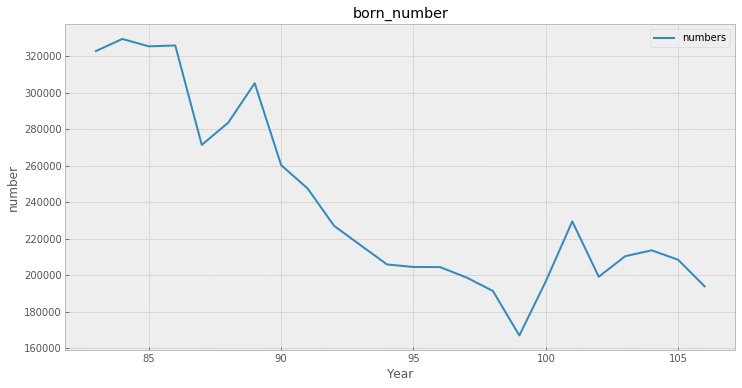

In [3]:
#read born data
file_born = os.path.join(path,"baby.xlsx")
born_data = pd.read_excel(file_born)


plt.style.use('ggplot')
plt.style.use('bmh')


born_data.plot(x="Year",y='numbers',kind='line',figsize=(12,6),title='born_number')

plt.ylabel("number")
plt.xlabel("Year")
plt.savefig(os.path.join(save_path,'born.png'))


In [4]:
University_data_103 = read_dataset("103_student.csv")
University_data_104 = read_dataset("104_student.csv")
University_data_105 = read_dataset("105_student.csv")
University_data_106 = read_dataset("106_student.csv")

University_registered_105 = read_dataset("105Registration_rate.csv")
University_registered_106 = read_dataset("106Registration_rate.csv")

University_data_103 = removeHeader(University_data_103)
University_data_104 = removeHeader(University_data_104)
University_data_105 = removeHeader(University_data_105)
University_data_106 = removeHeader(University_data_106)

University_registered_105 = removeHeader(University_registered_105)
University_registered_106 = removeHeader(University_registered_106)

#dataset split
data_103 = University_data_103.map(lambda line : line.split(','))
data_104 = University_data_104.map(lambda line : line.split(','))
data_105 = University_data_105.map(lambda line : line.split(','))
data_106 = University_data_106.map(lambda line : line.split(','))
registered_105_data = University_registered_105.map(lambda line : line.split(','))
registered_106_data = University_registered_106.map(lambda line : line.split(','))

In [34]:
sqlContext = SQLContext(sc)
#creat students' table
def CreatStudentTable(dataset):
    dataset =  dataset.map(lambda p:
                       Row(
                           Unumber = int(p[0]),
                           Name = str(p[1]),
                           StudyClassification = str(p[2]),
                           Degree = str(p[3]),
                           studentNumber = int(p[4]),
                           City = str(p[5])
                       ))
    return dataset

def CreatRegisteredTable(dataset):
    dataset = dataset.map(lambda p:
                        Row(
                            System = str(p[1]),
                            SchoolClass = str(p[2]),
                            Name = str(p[3]),
                            StudyClassification = str(p[4]),
                            Degree = str(p[5]),
                            Rate = float(p[6])
                            ))
    return dataset


In [35]:
student_number_103 = CreatStudentTable (data_103)
student_number_104 = CreatStudentTable (data_104)
student_number_105 = CreatStudentTable (data_105)
student_number_106 = CreatStudentTable (data_106)

registered_105 = CreatRegisteredTable(registered_105_data)
registered_106 = CreatRegisteredTable(registered_106_data)

student_103_df = sqlContext.createDataFrame(student_number_103)
student_104_df = sqlContext.createDataFrame(student_number_104)
student_105_df = sqlContext.createDataFrame(student_number_105)
student_106_df = sqlContext.createDataFrame(student_number_106)

student_103_df.registerTempTable("student_103")
student_104_df.registerTempTable("student_104")
student_105_df.registerTempTable("student_105")
student_106_df.registerTempTable("student_106")

In [36]:
registered_105_df = sqlContext.createDataFrame(registered_105)
registered_106_df = sqlContext.createDataFrame(registered_106)

registered_105_df.registerTempTable("registered_105")
registered_106_df.registerTempTable("registered_106")

In [8]:
studentNumbers_103 = sqlContext.sql("""SELECT S_3.Degree,sum(S_3.studentNumber) Num_103
                                    FROM student_103 S_3
                                    GROUP BY Degree""")

studentNumbers_104 = sqlContext.sql("""SELECT sum(studentNumber) Num_104
                                    FROM student_104 
                                    GROUP BY Degree""")

studentNumbers_105 = sqlContext.sql("""SELECT sum(studentNumber) Num_105
                                    FROM student_105 
                                    GROUP BY Degree""")

studentNumbers_106 = sqlContext.sql("""SELECT sum(studentNumber) Num_106
                                    FROM student_106  
                                    GROUP BY Degree""")

studentNumbers_103 = studentNumbers_103.toPandas()
studentNumbers_104 = studentNumbers_104.toPandas()
studentNumbers_105 = studentNumbers_105.toPandas()
studentNumbers_106 = studentNumbers_106.toPandas()


studentNumbers = studentNumbers_103.join(studentNumbers_104,rsuffix="Num_104")
studentNumbers = studentNumbers.join(studentNumbers_105,rsuffix="Num_105")
studentNumbers = studentNumbers.join(studentNumbers_106,rsuffix="Num_106")
studentNumbers
Image = studentNumbers.set_index("Degree")
Image = Image.T
Image


#Image['Num_103'].plot(kind='bar',title="Student_Numbers_103",figsize=(20,10))
#
#plt.show()

Degree,4 Bachelor,Master,others,2 Associate,5 Associate,Doctor,Bachelor,2 Bachelor
Num_103,486309,172968,511,9786,89484,30549,513500,36742
Num_104,481079,170428,454,8323,89143,29333,517653,36032
Num_105,466050,169538,668,7259,88425,28821,512529,36151
Num_106,447171,168783,658,6061,84777,28346,503130,34968


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


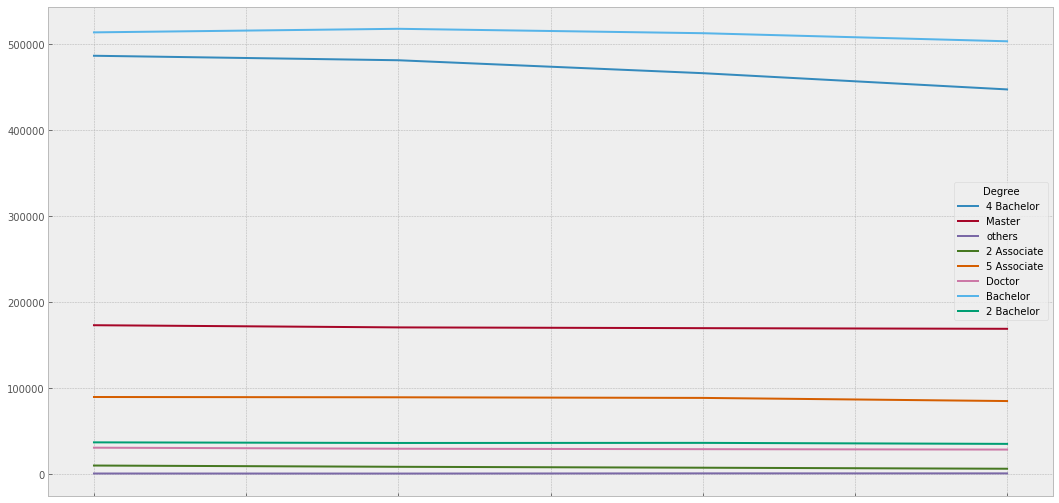

In [9]:
Image.cumsum()
Image.plot(figsize=(18,9))
plt.savefig(os.path.join(save_path,'fig-5.png'))
plt.show()

In [10]:
studentNumbers_103 = sqlContext.sql("""SELECT Name,studentNumber Bachelor
                                    FROM student_103
                                    WHERE Degree = 'Bachelor' and StudyClassification='D 日'""").toPandas()
studentNumbers_103

,Name,Bachelor
0,國立政治大學,9639
1,國立清華大學,6280
2,國立臺灣大學,16505
3,國立臺灣師範大學,7865
4,國立成功大學,11436
5,國立中興大學,8074
6,國立交通大學,5432
7,國立中央大學,6098
8,國立中山大學,4655
9,國立臺灣海洋大學,5409


In [11]:
studentNumbers_103 = sqlContext.sql("""SELECT Name,sum(studentNumber) Num_103
                                    FROM student_103
                                    GROUP BY Name""").toPandas()
studentNumbers_104 = sqlContext.sql("""SELECT Name,sum(studentNumber) Num_104
                                    FROM student_104 
                                    GROUP BY Name""").toPandas()
studentNumbers_105 = sqlContext.sql("""SELECT Name,sum(studentNumber) Num_105
                                    FROM student_105
                                    GROUP BY Name""").toPandas()
studentNumbers_106 = sqlContext.sql("""SELECT Name,sum(studentNumber) Num_106
                                    FROM student_106 
                                    GROUP BY Name""").toPandas()
school_class_105 = sqlContext.sql("""SELECT distinct Name,System, SchoolClass
                                FROM registered_105""").toPandas()

studentNumbers = pd.merge(studentNumbers_103,studentNumbers_104,on='Name', how='inner')
studentNumbers = pd.merge(studentNumbers,studentNumbers_105,on='Name', how='inner')
studentNumbers = pd.merge(studentNumbers,studentNumbers_106,on='Name', how='inner')
studentNumbers = pd.merge(studentNumbers,school_class_105,on='Name', how='inner')
studentNumbers

,Name,Num_103,Num_104,Num_105,Num_106,System,SchoolClass
0,國立高雄海洋科技大學,7819,7745,7738,7694,技職,公立
1,國立臺南護理專科學校,1931,1946,1944,1955,技職,公立
2,國立暨南國際大學,5982,6139,6353,6361,一般,公立
3,淡江大學,27060,27041,26619,26032,一般,私立
4,國立臺灣科技大學,10371,10446,10729,11019,技職,公立
5,仁德醫護管理專科學校,6455,6503,6630,6601,技職,私立
6,國立澎湖科技大學,3014,2984,3018,3008,技職,公立
7,國立虎尾科技大學,10217,10062,10091,10188,技職,公立
8,南榮科技大學,3598,3889,2904,2211,技職,私立
9,敏惠醫護管理專科學校,3875,3819,3897,3858,技職,私立


In [12]:
def studentNumberPercent(name,title):
    count = []
    Less_3000 = studentNumbers[studentNumbers[name]<=3000].count()
    Less_6000 = studentNumbers[(studentNumbers[name]<=6000) & (studentNumbers[name] > 3000)].count()
    Less_9000 = studentNumbers[(studentNumbers[name]<=9000) & (studentNumbers[name] > 6000)].count()
    Less_12000 = studentNumbers[(studentNumbers[name]<=12000) & (studentNumbers[name] > 9000)].count()
    More_12001 = studentNumbers[(studentNumbers[name]> 12000)].count()
    count.append(Less_3000['Name'])
    count.append(Less_6000['Name'])
    count.append(Less_9000['Name'])
    count.append(Less_12000['Name'])
    count.append(More_12001['Name'])
    drawPie(count,title)

def drawPie(count,title):
    fig, ax = plt.subplots()
    labels = '3000','6000','9000','12000','12001'
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','red']
    explode = (0, 0.1, 0, 0)

    ax.pie(count,  labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90,radius=1.2)

    ax.set(aspect="equal", title=title)#設置標題以及圖形的對稱
    
    plt.savefig(os.path.join(save_path,title+'.png'))

    plt.show()


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


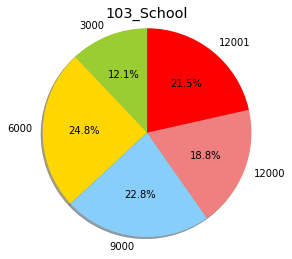

In [13]:
studentNumberPercent('Num_103','103_School')

D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


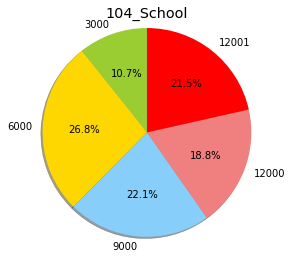

In [14]:
studentNumberPercent('Num_104','104_School')

D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


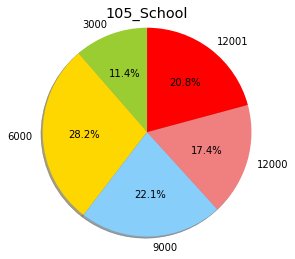

In [15]:
studentNumberPercent('Num_105','105_School')

D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


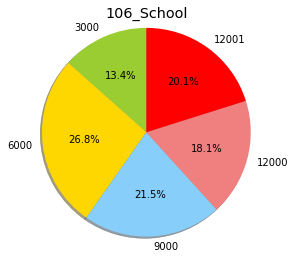

In [16]:
studentNumberPercent('Num_106','106_School')

In [55]:
Numbers_105 = sqlContext.sql("""SELECT Unumber,Name,sum(studentNumber) Numbers,City
                                FROM student_105
                                GROUP BY Unumber, Name, City""")
school_class_105 = sqlContext.sql("""SELECT distinct Name,System, SchoolClass
                                FROM registered_105""")
Semester_105 = Numbers_105.join(school_class_105,Numbers_105.Name == school_class_105.Name,"leftouter")
Less_than_3000_105 = Semester_105.filter((Semester_105["Numbers"]<=3000))
Image = Less_than_3000_105.select('SchoolClass').groupBy('SchoolClass').count()
Image_pandas = Image.toPandas().set_index("SchoolClass")
Image_pandas.T

SchoolClass,公立,私立
count,5,15


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


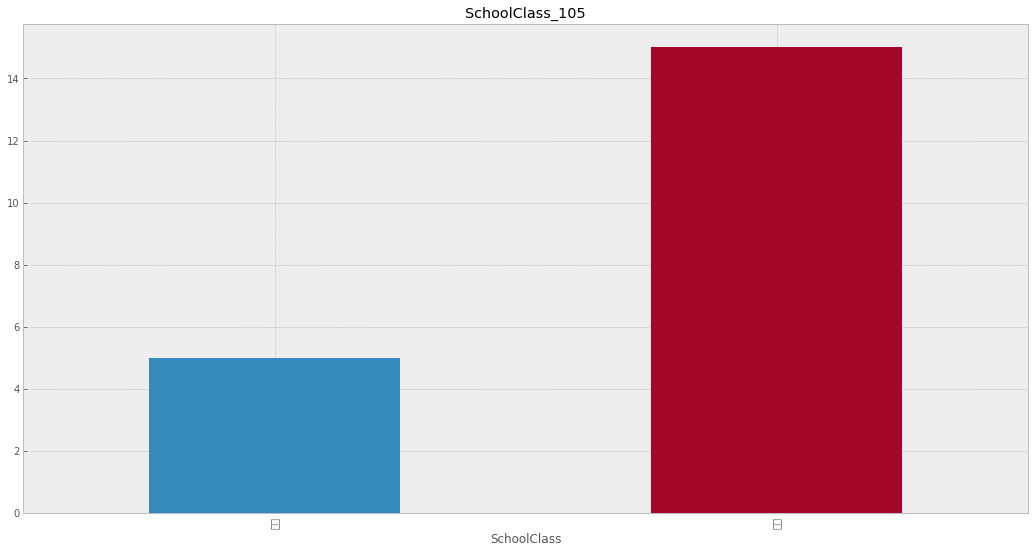

In [18]:
Image_pandas['count'].plot(kind='bar', title='SchoolClass_105',figsize=(18,9))
plt.savefig(os.path.join(save_path,"fig-6.png"))
plt.show()

In [19]:
Image = Less_than_3000_105.select('S.Name','Numbers')
Image_pandas = Image.toPandas()
Image_pandas

,Name,Numbers
0,國立臺南護理專科學校,1944
1,慈濟科技大學,2924
2,南榮科技大學,2904
3,國立體育大學,2437
4,中信金融管理學院,331
5,蘭陽技術學院,1463
6,大同技術學院,2434
7,稻江科技暨管理學院,2186
8,法鼓文理學院,238
9,亞太創意技術學院,1410


In [64]:
Image = Less_than_3000_105.select('City').groupBy('City').count()
Image_pandas = Image.toPandas().set_index('City')
Image_pandas.T

City,12 高雄市,10 嘉義縣,02 宜蘭縣,20 嘉義市,50 高雄市,14 臺東縣,30 臺北市,15 花蓮縣,01 新北市,21 臺南市,17 基隆市,03 桃園市,11 臺南市,05 苗栗縣
count,1,1,1,1,1,1,1,3,3,2,1,1,2,1


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


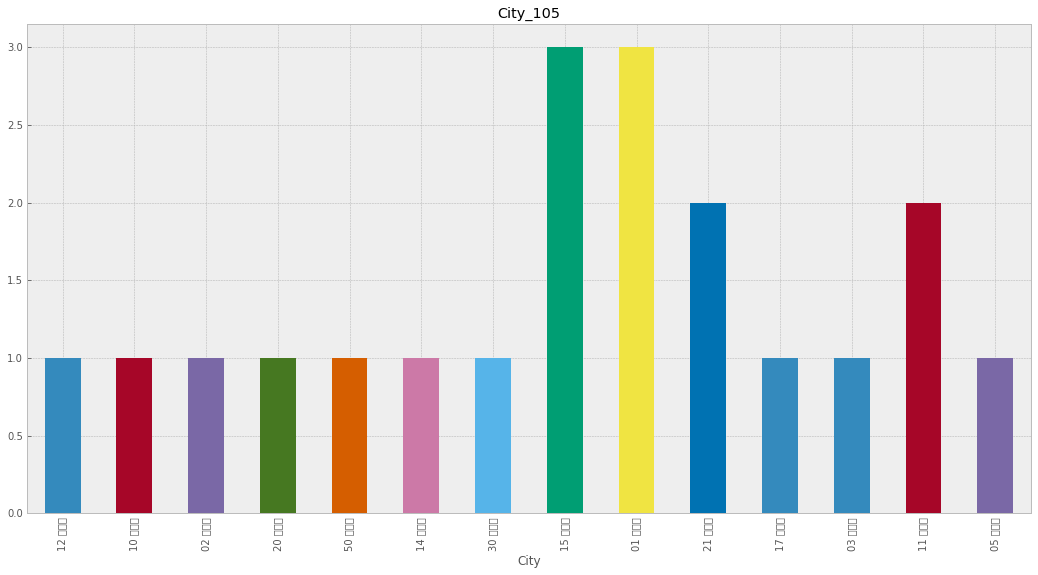

In [66]:
Image_pandas['count'].plot(kind='bar', title='City_105',figsize=(18,9))
plt.savefig(os.path.join(save_path,"fig-8.png"))
plt.show()

In [67]:
Numbers_106 = sqlContext.sql("""SELECT Unumber,Name,sum(studentNumber) Numbers,City
                                FROM student_106 as S
                                GROUP BY Unumber, Name, City""")
school_class_106 = sqlContext.sql("""SELECT distinct Name,System, SchoolClass
                                FROM registered_106""")
Semester_106 = Numbers_106.join(school_class_106,Numbers_106.Name == school_class_106.Name,"leftouter")

Less_than_3000_106 = Semester_106.filter((Semester_106["Numbers"]<=3000))
Image = Less_than_3000_106.select('SchoolClass').groupBy('SchoolClass').count()
Image_pandas = Image.toPandas().set_index("SchoolClass")
Image_pandas.T

SchoolClass,公立,私立
count,5,18


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


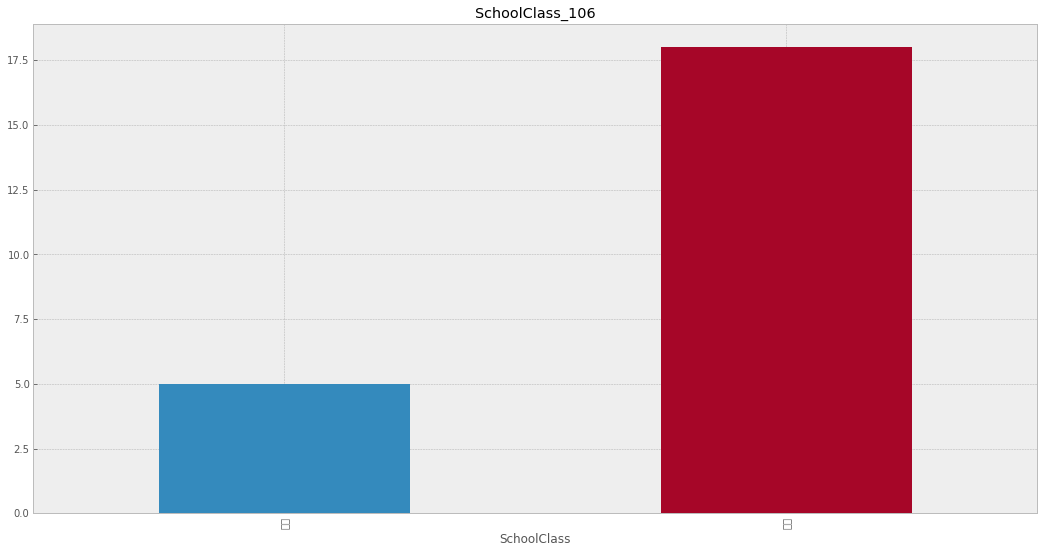

In [21]:
Image_pandas['count'].plot(kind='bar', title='SchoolClass_106',figsize=(18,9))
plt.savefig(os.path.join(save_path,"fig-7.png"))
plt.show()

In [22]:
Image = Less_than_3000_106.select('S.Name','Numbers')
Image_pandas = Image.toPandas()
Image_pandas

,Name,Numbers
0,國立臺南護理專科學校,1955
1,慈濟科技大學,2947
2,南榮科技大學,2211
3,台灣首府大學,2730
4,國立體育大學,2464
5,中信金融管理學院,485
6,蘭陽技術學院,1058
7,大同技術學院,2112
8,稻江科技暨管理學院,2267
9,法鼓文理學院,267


In [68]:
Image = Less_than_3000_106.select('City').groupBy('City').count()
Image_pandas = Image.toPandas().set_index('City')
Image_pandas.T

City,04 新竹縣,12 高雄市,10 嘉義縣,02 宜蘭縣,20 嘉義市,50 高雄市,14 臺東縣,30 臺北市,15 花蓮縣,01 新北市,21 臺南市,17 基隆市,03 桃園市,11 臺南市,05 苗栗縣
count,1,2,1,1,1,1,1,1,3,3,2,1,1,3,1


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


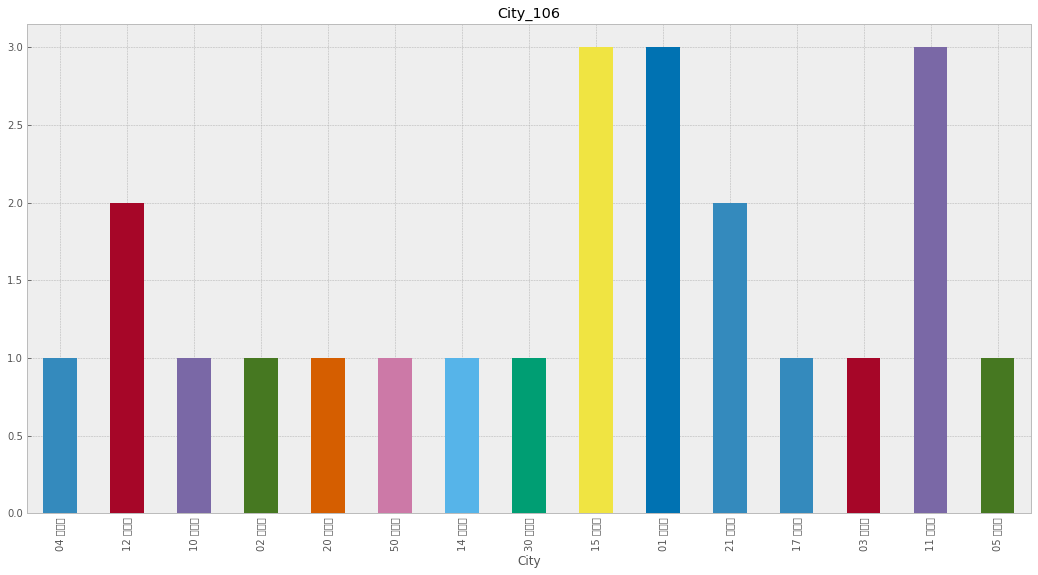

In [69]:
Image_pandas['count'].plot(kind='bar', title='City_106',figsize=(18,9))
plt.savefig(os.path.join(save_path,"fig-9.png"))
plt.show()

In [23]:
Less_than_3000_105 = Semester_105.filter((Semester_105["Numbers"]<=3000) & (Semester_105['SchoolClass'] == '私立') )
Less_than_3000_105_Pandas = Less_than_3000_105.toPandas()
Image = Less_than_3000_105.select('System').groupBy('System').count()

Image_pandas = Image.toPandas().set_index("System")
Image_pandas.T


System,技職,一般
count,10,5


In [24]:
Numbers_Name_105 =Less_than_3000_105.select('S.Name','Numbers')

D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


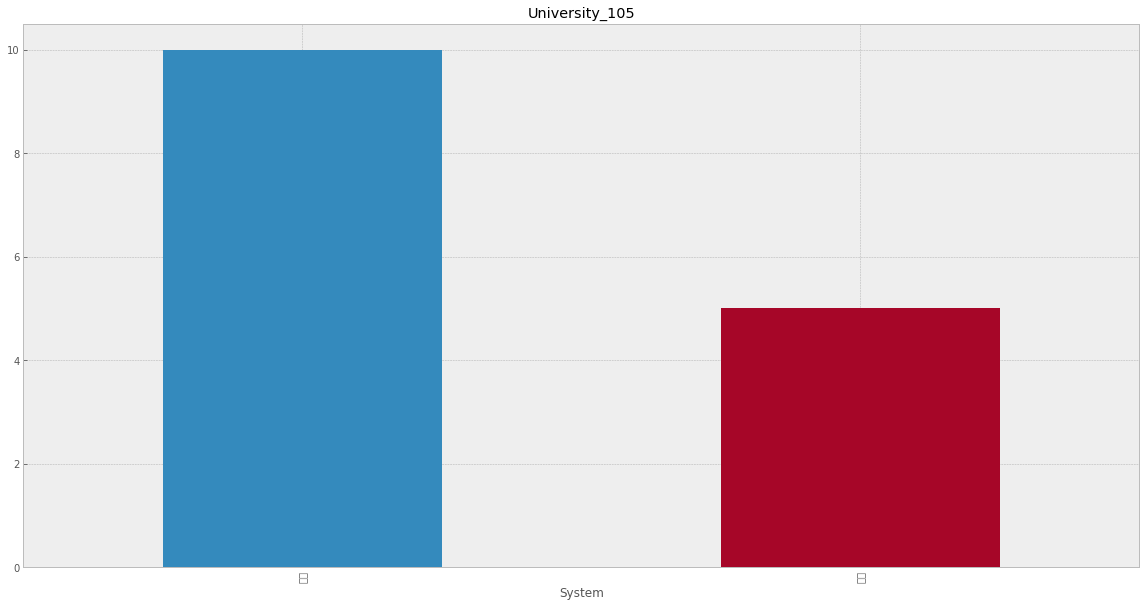

In [25]:
Image_pandas['count'].plot(kind='bar',title="University_105",figsize=(20,10))
plt.savefig(os.path.join(save_path,'fig-2.png'))
plt.show()

In [26]:
Less_than_3000_106 = Semester_106.filter((Semester_106['Numbers']<=3000) & (Semester_106['SchoolClass']=='私立'))
Image = Less_than_3000_106.select('System').groupBy('System').count()
Image_pandas = Image.toPandas().set_index("System")
Image_pandas.T

System,技職,一般
count,12,6


In [27]:
Numbers_Name_106 = Less_than_3000_106.select('S.Name')

D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


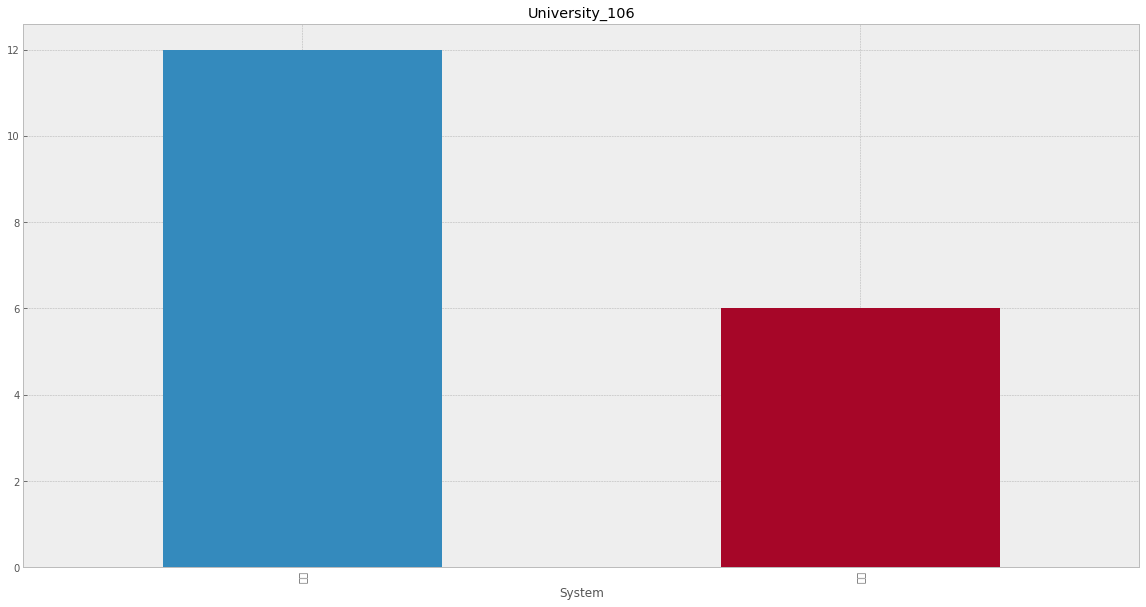

In [28]:
Image_pandas['count'].plot(kind='bar',title="University_106",figsize=(20,10))
plt.savefig(os.path.join(save_path,'fig-3.png'))
plt.show()

In [29]:
Rate = sqlContext.sql("""SELECT  R5.Name R_N,R5.SchoolClass,R5.Rate 105_Rate,R6.Rate 106_Rate,R5.Degree
                  FROM registered_105 as R5, registered_106 as R6
                  WHERE   R5.Name = R6.Name and R5.Rate<60 and R6.Rate<60  and R5.StudyClassification = R6.StudyClassification  
                          and R5.StudyClassification ='D 日' and R5.Degree = R6.Degree """)
Rate_count = Rate.select('Degree').groupBy('Degree').count()
Rate_count_Pandas = Rate_count.toPandas().set_index("Degree")
Rate_count_Pandas.T

Degree,4 Bachelor,Master,5 Associate,Bachelor,2 Bachelor
count,8,4,4,3,5


In [30]:
Rate.toPandas()

,R_N,SchoolClass,105_Rate,106_Rate,Degree
0,嘉南藥理大學,私立,40.28,53.95,2 Bachelor
1,南開科技大學,私立,28.89,38.24,2 Bachelor
2,明道大學,私立,53.92,54.91,Bachelor
3,台灣首府大學,私立,50.57,51.22,Bachelor
4,南榮科技大學,私立,30.53,22.00,5 Associate
5,南臺科技大學,私立,53.13,46.10,2 Bachelor
6,高苑科技大學,私立,55.49,50.34,4 Bachelor
7,南亞技術學院,私立,51.20,44.04,4 Bachelor
8,和春技術學院,私立,43.28,23.81,4 Bachelor
9,中州科技大學,私立,46.62,30.88,4 Bachelor


D:\Ancaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


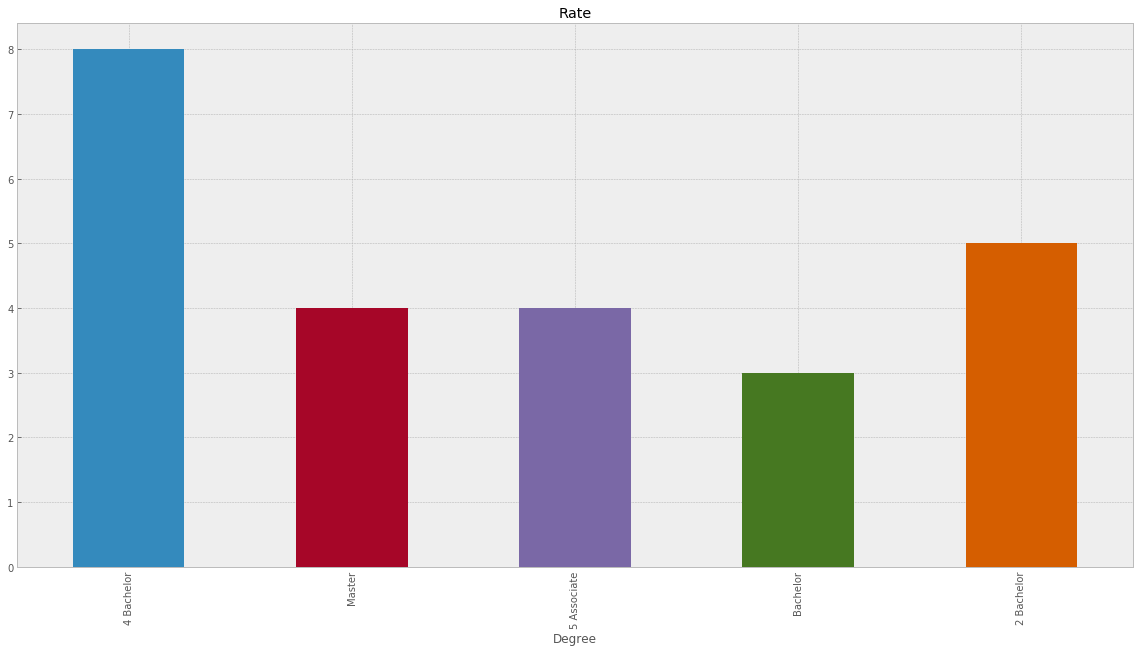

In [31]:
Rate_count_Pandas['count'].plot(kind='bar', title='Rate',figsize=(20,10))
plt.savefig(os.path.join(save_path,"fig-4.png"))
plt.show()

In [32]:
Name_less_than = Rate.join(Numbers_Name_105, Rate.R_N == Numbers_Name_105.Name, 'inner')
Name_less_than = Name_less_than.join(Numbers_Name_106 , Name_less_than.R_N ==Numbers_Name_106.Name, 'inner')
Name_less_than.select('R_N','SchoolClass','105_Rate','106_Rate','Degree','Numbers').toPandas()

,R_N,SchoolClass,105_Rate,106_Rate,Degree,Numbers
0,南榮科技大學,私立,30.53,22.00,5 Associate,2904
1,南榮科技大學,私立,18.74,22.07,4 Bachelor,2904
2,亞太創意技術學院,私立,46.15,6.00,4 Bachelor,1410
3,臺灣觀光學院,私立,53.33,53.33,Master,1300
4,臺灣觀光學院,私立,29.52,25.00,5 Associate,1300
5,臺灣觀光學院,私立,47.73,17.84,4 Bachelor,1300
6,華梵大學,私立,43.84,27.27,Bachelor,2746
7,大漢技術學院,私立,40.00,0.00,2 Bachelor,1497
